# Прогнозирование оттока клиентов. Телеком
Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  

**Описание услуг**  
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:  
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных
Данные хранятся в таблицах в базе данных PostgreSQL:  
- **contract** — информация о договоре,
- **personal** — персональные данные клиента,
- **internet** — информация об интернет-услугах,
- **phone** — информация об услугах телефонии.  

Таблица **contract**
- customerID — ID пользователя,
- BeginDate — дата начала действия,
- EndDate — дата окончания действия,
- Type — тип оплаты (раз в год или помесячно),
- PaperlessBilling — безбумажный расчётный лист,
- PaymentMethod — тип платежа,
- MonthlyCharges — расход за месяц,
- TotalCharges — общие расходы.  

Таблица **personal**
- customerID — ID пользователя,
- gender — пол,
- SeniorCitizen — является ли абонент пенсионером,
- Partner — есть ли у абонента супруг/супруга,
- Dependents — есть ли у абонента дети.  

Таблица **internet**
- customerID — ID пользователя,
- InternetService — тип подключения,
- OnlineSecurity — блокировка небезопасных сайтов,
- OnlineBackup — облачное хранилище файлов для резервного копирования данных,
- DeviceProtection — антивирус,
- TechSupport — выделенная линия технической поддержки,
- StreamingTV — стриминговое телевидение,
- StreamingMovies — каталог фильмов.  

Таблица **phone**
- customerID — ID пользователя,
- MultipleLines — подключение телефонного аппарата к нескольким линиям одновременно.  

Информация о договорах актуальна на 1 февраля 2020.

## Импорт библиотек и подготовка окружения

In [1]:
!pip install catboost -q

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook
from sqlalchemy import create_engine
from datetime import datetime, date

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool

import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

pd.set_option('max_columns', None)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

# Зафиксируем random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## 1. Загрузка данных

In [4]:
db_config = {
'user': USER, # имя пользователя,
'pwd': PASSWORD, # пароль,
'host': HOST,
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

### Таблица `contract`

In [5]:
query = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(query, con=engine)
contract.columns = ['CustomerID' if x == 'customerID' else x for x in contract.columns]
display(contract.head())
print(contract.info())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


In [6]:
print('Количество уникальных пользователей:', contract.CustomerID.nunique())

Количество уникальных пользователей: 7043


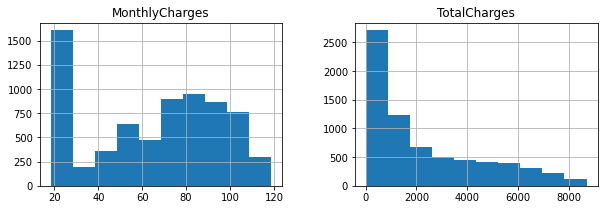

In [7]:
contract.hist(figsize=(10, 3));

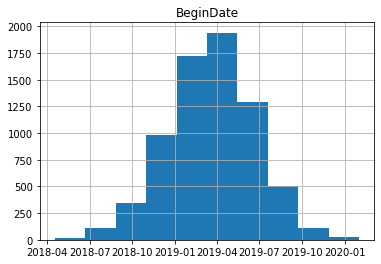

In [8]:
contract.BeginDate.hist()
plt.title('BeginDate');

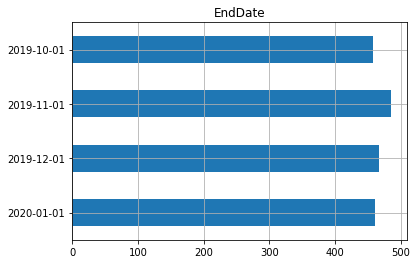

In [9]:
contract.EndDate.value_counts().sort_index(ascending=False).plot.barh(grid=True);
plt.title('EndDate');

In [10]:
print('Уникальные значения столбца Type:', *contract.Type.unique()+' |')
print('Уникальные значения столбца PaymentMethod:', *contract.PaymentMethod.unique()+' |')
print('Уникальные значения столбца PaperlessBilling:', *contract.PaperlessBilling.unique()+' |')

Уникальные значения столбца Type: Two year | Month-to-month | One year |
Уникальные значения столбца PaymentMethod: Bank transfer (automatic) | Mailed check | Electronic check | Credit card (automatic) |
Уникальные значения столбца PaperlessBilling: Yes | No |


In [11]:
# Приведем значения Yes/No к целочисленному представлению.
contract['PaperlessBilling'] = contract['PaperlessBilling'].map({'Yes': 1, 'No': 0})
contract['PaperlessBilling'].head()

0    1
1    0
2    1
3    0
4    1
Name: PaperlessBilling, dtype: int64

### Таблица `personal`

In [12]:
query = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(query, con=engine)
personal.columns = ['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents']
display(personal.head())
print(personal.info())

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [13]:
print('Количество уникальных пользователей:', personal.CustomerID.nunique())

Количество уникальных пользователей: 7043


In [14]:
print('Уникальные значения столбца Gender:', personal.Gender.unique())
print('Уникальные значения столбца SeniorCitizen:', personal.SeniorCitizen.unique())
print('Уникальные значения столбца Partner:', *personal.Partner.unique()+' |')
print('Уникальные значения столбца Dependents:', *personal.Dependents.unique()+' |')

Уникальные значения столбца Gender: ['Female' 'Male']
Уникальные значения столбца SeniorCitizen: [0 1]
Уникальные значения столбца Partner: Yes | No |
Уникальные значения столбца Dependents: No | Yes |


In [15]:
# Приведем значения Yes/No к целочисленному представлению.
for col in ['Partner', 'Dependents']:
    personal[col] = personal[col].map({'Yes': 1, 'No': 0})
    
personal[['Partner', 'Dependents']].head()

,Partner,Dependents
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0


### Таблица `internet`

In [16]:
query = '''
SELECT c1 AS customerID, c2 AS InternetService, c3 AS OnlineSecurity, 
       c4 AS OnlineBackup, c5 AS DeviceProtection, c6 AS TechSupport, 
       c7 AS StreamingTV, c8 AS StreamingMovies
FROM telecom.internet
'''
internet = pd.read_sql_query(query, con=engine).iloc[1:]
internet.columns = ['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
display(internet.head())
print(internet.info())

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


In [17]:
print('Количество уникальных пользователей в таблице internet:', internet.CustomerID.nunique())

Количество уникальных пользователей в таблице internet: 5517


In [18]:
for col in internet.columns[1:]:
    print(f'Уникальные значения столбца {col}:', *internet[col].unique()+' |')

Уникальные значения столбца InternetService: DSL | Fiber optic |
Уникальные значения столбца OnlineSecurity: No | Yes |
Уникальные значения столбца OnlineBackup: Yes | No |
Уникальные значения столбца DeviceProtection: No | Yes |
Уникальные значения столбца TechSupport: No | Yes |
Уникальные значения столбца StreamingTV: No | Yes |
Уникальные значения столбца StreamingMovies: No | Yes |


In [19]:
# Приведем значения Yes/No к целочисленному представлению.
for col in internet.columns[2:]:
    internet[col] = internet[col].map({'Yes': 1, 'No': 0})
    
internet[internet.columns[2:]].head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,0,1,0,0,0,0
2,1,0,1,0,0,0
3,1,1,0,0,0,0
4,1,0,1,1,0,0
5,0,0,0,0,0,0


### Таблица `phone`

In [20]:
query = '''
SELECT c1 AS customerID, c2 AS MultipleLines
FROM telecom.phone
'''

phone = pd.read_sql_query(query, con=engine).iloc[1:]
phone.columns = ['CustomerID', 'MultipleLines']
display(phone.head())
print(phone.info())

,CustomerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [21]:
print('Количество уникальных пользователей в таблице phone:', phone.CustomerID.nunique())

Количество уникальных пользователей в таблице phone: 6361


In [22]:
print('Уникальные значения столбца MultipleLines:', *phone['MultipleLines'].unique()+' |')

Уникальные значения столбца MultipleLines: No | Yes |


In [23]:
# Приведем значения Yes/No к целочисленному представлению.
phone['MultipleLines'] = phone['MultipleLines'].map({'Yes': 1, 'No': 0})

phone['MultipleLines'].head()

1    0
2    0
3    0
4    1
5    1
Name: MultipleLines, dtype: int64

**Резюме** Пропуски есть только в таблице `contracts`, в столбцах `TotalCharges` и `EndDate`.

### Объединение таблиц

In [24]:
data = contract\
.merge(personal, how='outer', on='CustomerID')\
.merge(internet, how='outer', on='CustomerID')\
.merge(phone, how='outer', on='CustomerID')

In [25]:
display(data.head())
print(data.info())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,None,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN
1,3115-CZMZD,2020-02-01,None,Two year,0,Mailed check,20.25,NaN,Male,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5709-LVOEQ,2020-02-01,None,Two year,0,Mailed check,80.85,NaN,Female,0,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   int64  
 11  Dependents        7043 non-null   int64  
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   float64
 14  OnlineBackup      5517 non-null   float64
 15  DeviceProtection  5517 non-null   float64
 16  TechSupport       5517 non-null   float64


### Краткое резюме

На данном этапе мы загрузили данные из базы данных, исследовали их, провели небольшую предобработку и обединили в единую таблицу `data`.  
Все таблицы из задачи присутствуют.

## 2. Исследовательский анализ данных

### 2.1 Как распеределены величины ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. 

In [26]:
churned_mask = data['EndDate'].notna()

In [27]:
print('Количество ушедших клиентов:', data[churned_mask].shape[0])
print('Количество действующих клиентов:', data[~churned_mask].shape[0])

Количество ушедших клиентов: 1869
Количество действующих клиентов: 5174


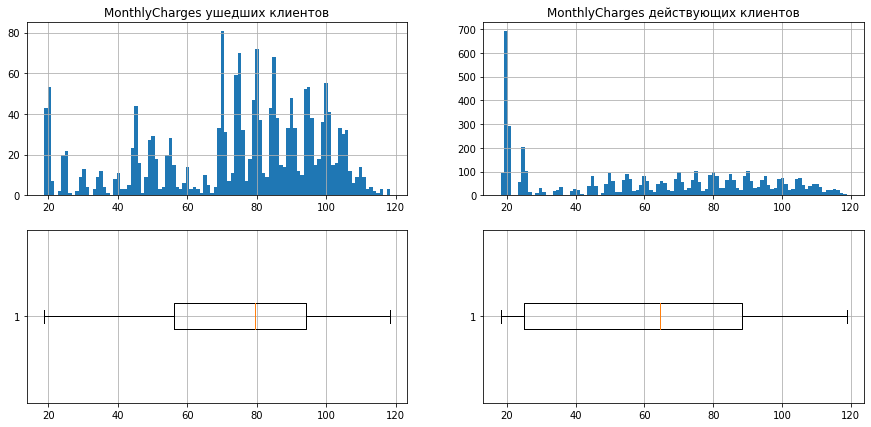

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

ax[0, 0].hist(data[churned_mask]['MonthlyCharges'], bins=100)
ax[0, 0].set_title('MonthlyCharges ушедших клиентов')
ax[0, 0].grid()

ax[1, 0].boxplot(data[churned_mask]['MonthlyCharges'], vert=False)
ax[1, 0].grid()


ax[0, 1].hist(data[~churned_mask]['MonthlyCharges'], bins=100)
ax[0, 1].set_title('MonthlyCharges действующих клиентов')
ax[0, 1].grid()

ax[1, 1].boxplot(data[~churned_mask]['MonthlyCharges'],  vert=False)
ax[1, 1].grid()

In [29]:
print("Ушедшие: \n", data[churned_mask]['MonthlyCharges'].describe())
print("Действующие: \n", data[~churned_mask]['MonthlyCharges'].describe())

Ушедшие: 
 count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64
Действующие: 
 count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64


Ежемесячные платежи действующих клиентов по медиане меньше (64 у.е.) нежели платежи ушедших клиентов (80 у.е.)

### 2.2 Есть ли зависимость от опций использования интернета и мобильной связи?

Посмотрим, каковы доли пользователей интернета и телефонной связи среди ушедших и действующих клиентов.

In [30]:
print("Доля пользователей телефонной связи среди ушедших клиентов:", data[churned_mask].MultipleLines.notna().sum() / data[churned_mask].shape[0])
print("Доля пользователей телефонной связи среди действующих клиентов:", data[~churned_mask].MultipleLines.notna().sum() / data[~churned_mask].shape[0])

Доля пользователей телефонной связи среди ушедших клиентов: 0.9090422685928304
Доля пользователей телефонной связи среди действующих клиентов: 0.9010436799381523


In [31]:
print("Доля пользователей интернета среди ушедших клиентов:", data[churned_mask].InternetService.notna().sum() / data[churned_mask].shape[0])
print("Доля пользователей интернета среди действующих клиентов:", data[~churned_mask].InternetService.notna().sum() / data[~churned_mask].shape[0])

Доля пользователей интернета среди ушедших клиентов: 0.9395398608881755
Доля пользователей интернета среди действующих клиентов: 0.7269037495168148


**Резюме:** Среди ушедших клиентов доля пользователей интернета выше, нежели среди действующих клиентов.

In [32]:
print("Доля ушедших клиентов, пользовавшихся \
телефонной связью, среди всех пользователей телефонной связи:", data[churned_mask].MultipleLines.notna().sum() / data.MultipleLines.notna().sum())
print("Доля действующих клиентов, пользовавшихся \
телефонной связью, среди всех пользователей телефонной связи:", data[~churned_mask].MultipleLines.notna().sum() / data.MultipleLines.notna().sum())
print("Доля ушедших пользователей всего:", data[churned_mask].shape[0] /  data.shape[0])

Доля ушедших клиентов, пользовавшихся телефонной связью, среди всех пользователей телефонной связи: 0.2670963684955196
Доля действующих клиентов, пользовавшихся телефонной связью, среди всех пользователей телефонной связи: 0.7329036315044805
Доля ушедших пользователей всего: 0.2653698707936959


In [33]:
print("Доля ушедших клиентов, пользовавшихся \
интернетом, среди всех пользователей интернета:", data[churned_mask].InternetService.notna().sum() / data.InternetService.notna().sum())
print("Доля действующих клиентов, пользовавшихся \
интернетом, среди всех пользователей интернета:", data[~churned_mask].InternetService.notna().sum() / data.InternetService.notna().sum())
print("Доля ушедших пользователей всего:", data[churned_mask].shape[0] /  data.shape[0])

Доля ушедших клиентов, пользовавшихся интернетом, среди всех пользователей интернета: 0.3182889251404749
Доля действующих клиентов, пользовавшихся интернетом, среди всех пользователей интернета: 0.6817110748595251
Доля ушедших пользователей всего: 0.2653698707936959


**Резюме:** Похоже, что действующие клиенты пользуются интернетом немного реже, нежели ушедшие.

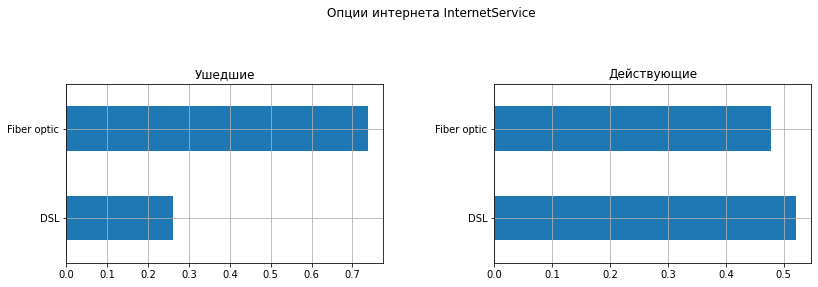

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
plt.suptitle('Опции интернета InternetService')
data[churned_mask]['InternetService'].value_counts(normalize=True).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['InternetService'].value_counts(normalize=True).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** Ушедшие клиенты чаще всего использовали Fiber optic, в то время как действующие клиенты используют обе опции практически в равной пропорции.

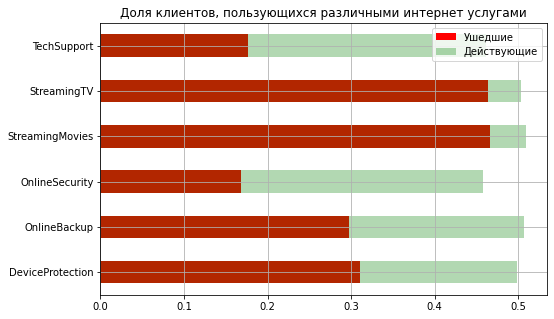

In [35]:
internet_bin_columns = internet.columns[2:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.title("Доля клиентов, пользующихся различными интернет услугами")
data[internet_bin_columns][churned_mask].mean().sort_index().plot.barh(grid=True, ax=ax, label='Ушедшие', color='r')
data[internet_bin_columns][~churned_mask].mean().sort_index().plot.barh(grid=True, ax=ax, label='Действующие', color='g', alpha=0.3);
plt.legend(loc='upper right');

**Резюме:** Среди действующих клиентов практически одинаково популярны все виды интернет-услуг - каждым видом услуг пользуются около 50% пользователей. Среди ушедших же гораздо более низкий процент использования каждой услуги.

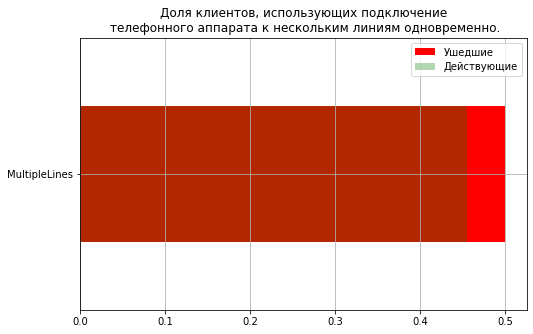

In [36]:
internet_bin_columns = internet.columns[2:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.title("Доля клиентов, использующих подключение\n телефонного аппарата к нескольким линиям одновременно.")
data[['MultipleLines']][churned_mask].mean().plot.barh(grid=True, ax=ax, label='Ушедшие', color='r')
data[['MultipleLines']][~churned_mask].mean().plot.barh(grid=True, ax=ax, label='Действующие', color='g', alpha=0.3);
plt.legend(loc='upper right');

**Резюме:** В обеих группах примерно одинаковая доля клиентов использует подключение телефонного аппарата к нескольким линиям одновременно.

### 2.3 Сколько в среднем длился период от BeginDate до EndDate (LTV)?

In [37]:
data['EndOrActualDate'] = data['EndDate'].where(data['EndDate'].notna(), date(2020, 2, 1))
data['DaysWithCompany'] = (data['EndOrActualDate'] - data['BeginDate']).dt.days

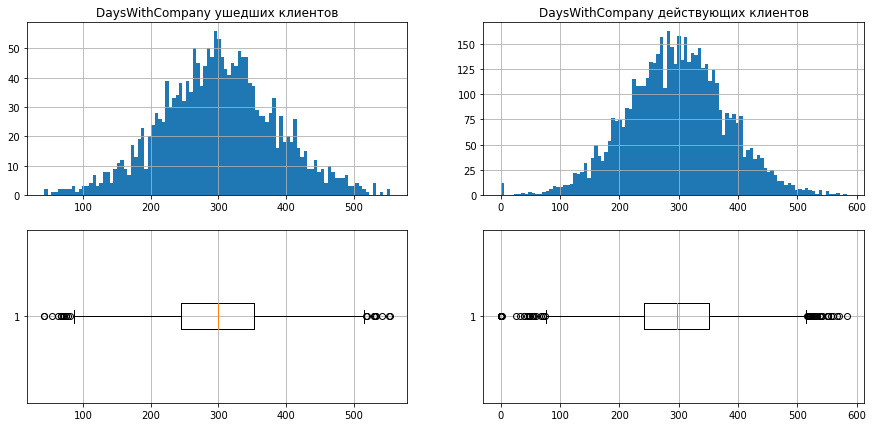

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))

ax[0, 0].hist(data[churned_mask]['DaysWithCompany'], bins=100)
ax[0, 0].set_title('DaysWithCompany ушедших клиентов')
ax[0, 0].grid()

ax[1, 0].boxplot(data[churned_mask]['DaysWithCompany'], vert=False)
ax[1, 0].grid()


ax[0, 1].hist(data[~churned_mask]['DaysWithCompany'], bins=100)
ax[0, 1].set_title('DaysWithCompany действующих клиентов')
ax[0, 1].grid()

ax[1, 1].boxplot(data[~churned_mask]['DaysWithCompany'],  vert=False)
ax[1, 1].grid()

Количество дней, которые провели клиенты с компанией практически одинаковое для обеих групп.

### 2.4 Какой тип оплаты чаще всего выбирали пользователи разных групп?


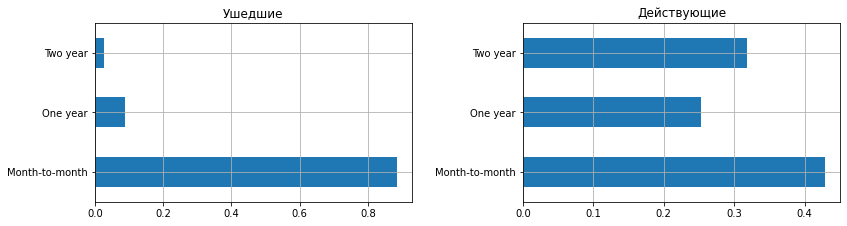

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
data[churned_mask]['Type'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['Type'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

Большинство ушедших клиентов платили ежемесячно, в то время как среди действующих клиентов также популярны способы оплаты сразу за один или за два года вперед.

Есть ли клиенты, которые на продолжительной основе платят раз в месяц? Иначе говоря, как распределено количество дней пребывания клиента в компании по типам оплаты?

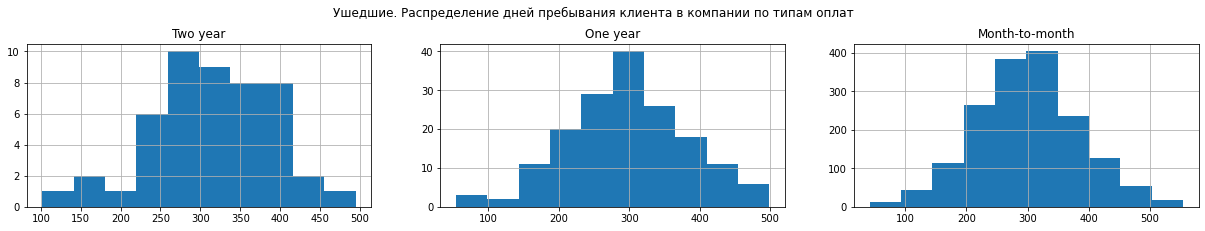

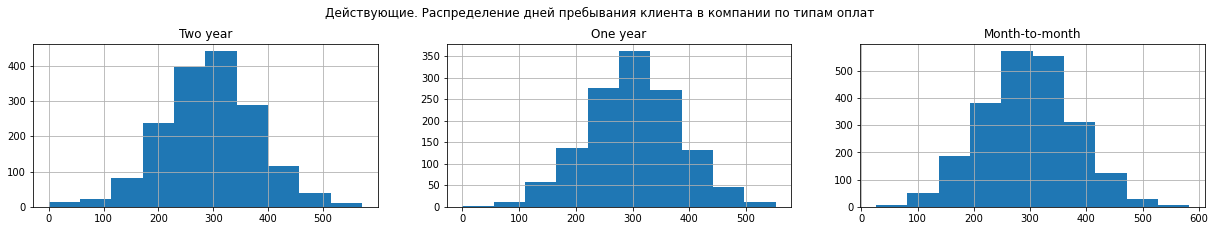

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(21, 3))
fig.suptitle('Ушедшие. Распределение дней пребывания клиента в компании по типам оплат', y=1.05)
for ax_, type_ in zip(ax, ['Two year', 'One year', 'Month-to-month']):
    ax_.hist(data[churned_mask][lambda x: x['Type'] == type_]['DaysWithCompany']);
    ax_.set_title(type_)
    ax_.grid()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(21, 3))
fig.suptitle('Действующие. Распределение дней пребывания клиента в компании по типам оплат', y=1.05)
for ax_, type_ in zip(ax, ['Two year', 'One year', 'Month-to-month']):
    ax_.hist(data[~churned_mask][lambda x: x['Type'] == type_]['DaysWithCompany']);
    ax_.set_title(type_)
    ax_.grid()
plt.show()

**Резюме:** Тип оплаты практически никак не влияет на то количество дней, которое клиент пробыл с компанией.

Посмотрим есть ли разница в распределении признака `PaperlessBilling` между различными группами клиентов:

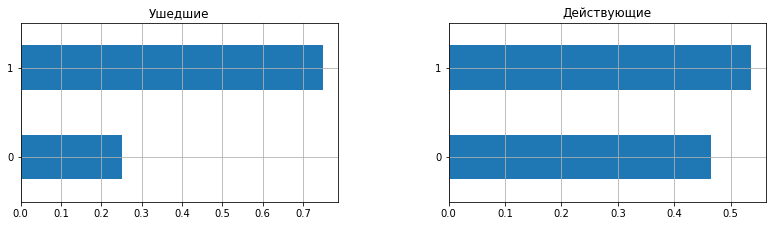

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
data[churned_mask]['PaperlessBilling'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['PaperlessBilling'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** Среди ушедших клиентов большинство использовали безбумажный расчетный лист, в то время как среди действующих клиентов доли тех, кто его использует и не использует практически равны.

Посмотрим есть ли разница в распредении признака `PaymentMethod` между различными группами клиентов:

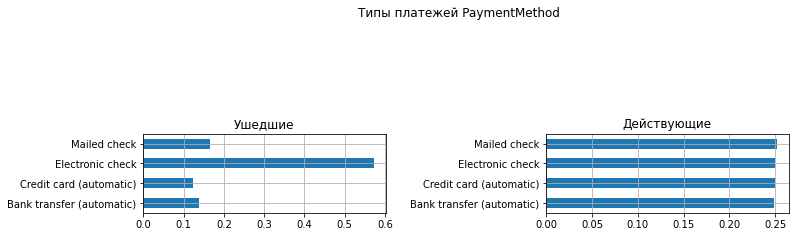

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=13.0)
plt.suptitle('Типы платежей PaymentMethod')
data[churned_mask]['PaymentMethod'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['PaymentMethod'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** Среди ушедших клиентов наиболее распространенным являлся тип платежа "Electronic check", в то время как среди действующих клиентов все виды платежей одинаково распространены.

### 2.5 Есть ли зависимость от признаков, описывающих клиента (пола, возраста, наличия партнера, детей)?

Посмотрим, есть ли зависимость от пола:

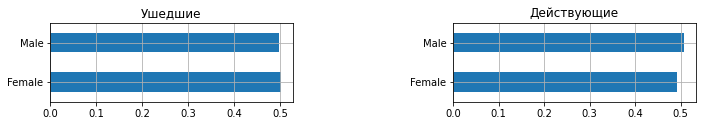

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=13.0)
data[churned_mask]['Gender'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['Gender'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** Распределения клиентов по полу примерно одинаковое в обоих группах.

Посмотрим, есть ли зависимость от возраста:

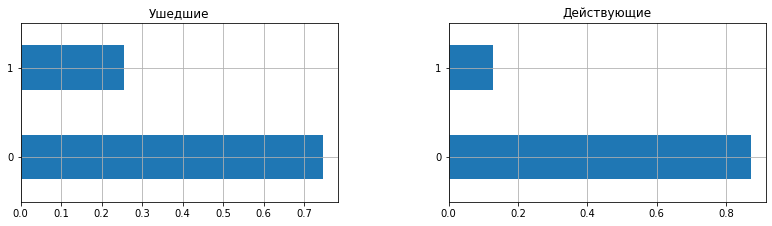

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
data[churned_mask]['SeniorCitizen'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['SeniorCitizen'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** Распределения клиентов по возрасту примерно одинаковое в обоих группах.

Посмотрим, есть ли зависимость от наличия партнера:

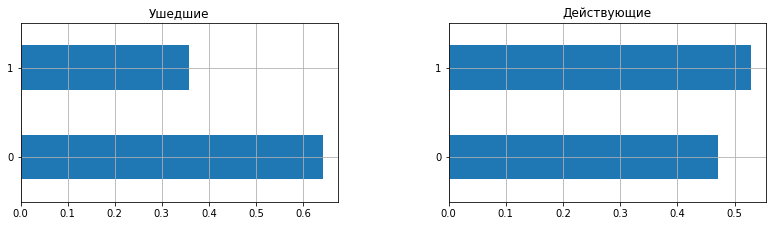

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
data[churned_mask]['Partner'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['Partner'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** У более чем половины действующих клиентов есть супруг/супруга, в то время как среди ушедших клиентов парнер есть лишь у менее чем 40% пользователей.

Посмотрим, есть ли зависимость от наличия детей:

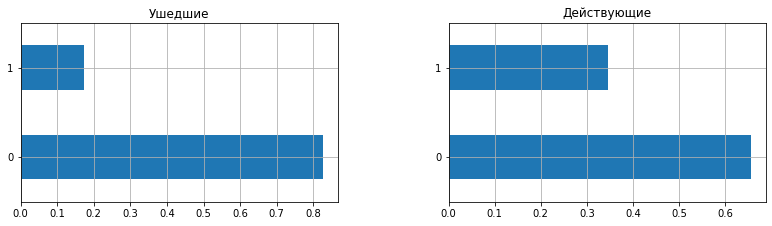

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.tight_layout(pad=8.0)
data[churned_mask]['Dependents'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[0], title='Ушедшие')
data[~churned_mask]['Dependents'].value_counts(normalize=True, dropna=False).sort_index().plot.barh(grid=True, ax=ax[1], title='Действующие');

**Резюме:** У более чем 30% действующих клиентов есть дети, в то время как среди ушедших клиентов дети есть лишь у менее чем 20% пользователей.

### 2.6 В какие месяца пришли клиенты, которые ушли?

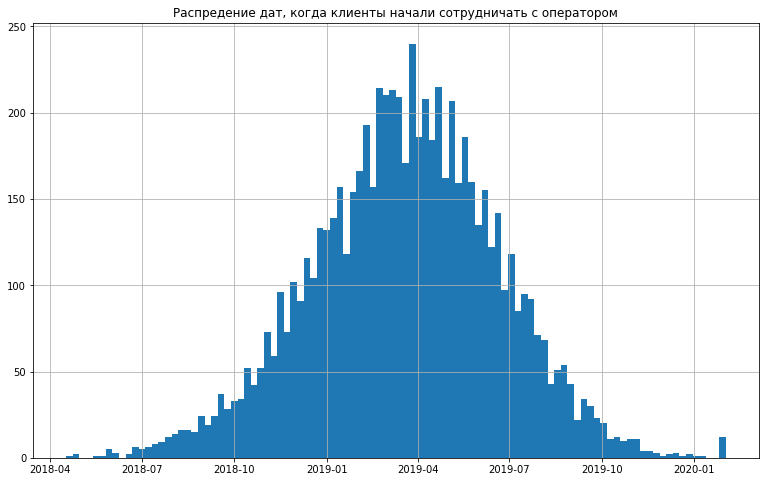

In [47]:
data['BeginDate'].hist(bins=100, figsize=(13, 8));
plt.title('Распредение дат, когда клиенты начали сотрудничать с оператором');

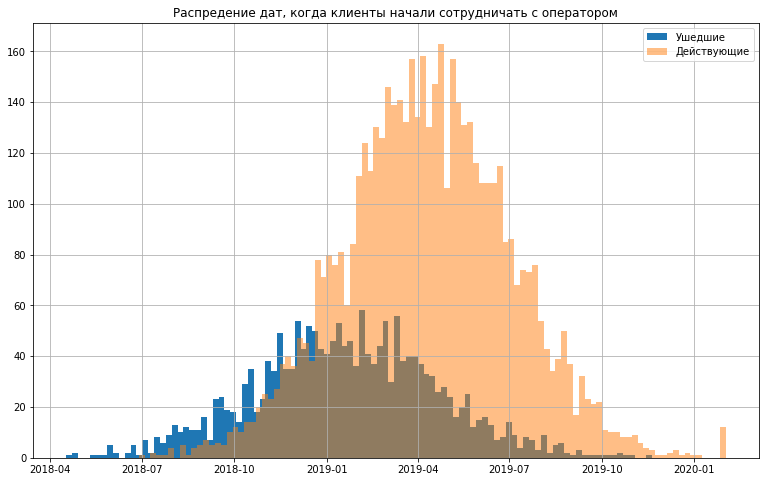

In [48]:
data['BeginDate'][churned_mask].hist(bins=100, label='Ушедшие', figsize=(13, 8))
data['BeginDate'][~churned_mask].hist(bins=100, alpha=0.5, label='Действующие');
plt.legend();
plt.title('Распредение дат, когда клиенты начали сотрудничать с оператором');

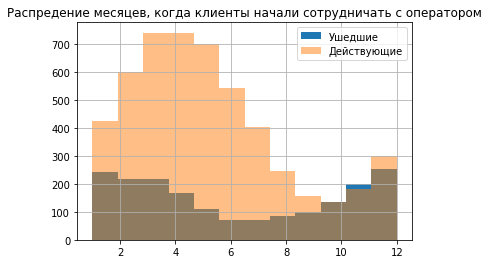

In [49]:
plt.hist((pd.DatetimeIndex(data['BeginDate'][churned_mask]).month), bins=12, label='Ушедшие')
plt.hist((pd.DatetimeIndex(data['BeginDate'][~churned_mask]).month), alpha=0.5, bins=12, label='Действующие')
plt.legend()
plt.grid()
plt.title('Распредение месяцев, когда клиенты начали сотрудничать с оператором');

Похоже, что большинство клиентов, которые ушли - впервые начали сотрудничать с оператором связи в январе либо в декабре, в то время как пик притока действующих по ныне клиентов пришелся на апрель. Однако, это может быть лишь особенность данных. Нам дан слишком коротки период, чтобы делать вывод, что здесь присутствует кака-либо закономерность.

### 2.7 Выделение целевой переменной. Обогащение данных новыми признаками.

In [50]:
# Выделим целевую переменную и сохраним ее столбец "Churned"
data['Churned'] = data['EndDate'].notna().astype('int')

In [51]:
# Заполним пропуски
data['InternetService'] = data['InternetService'].fillna('Not used')
data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']] = \
data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].fillna(-1)

На основе исследовательского анализа данных было принято исключить следующие признаки из обучения: 
`CustomerID`, '`BeginDate`, `EndDate`, `TotalCharges`, `Gender`, `EndOrActualDate`


In [52]:
# Сохраним признаки и таргет в переменные "features" и "target"
features = data.drop(columns=['CustomerID', 'BeginDate', 'EndDate', 'TotalCharges', 'Gender', 'EndOrActualDate', 'Churned'])
target = data['Churned']

In [53]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   SeniorCitizen     7043 non-null   int64  
 5   Partner           7043 non-null   int64  
 6   Dependents        7043 non-null   int64  
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   float64
 9   OnlineBackup      7043 non-null   float64
 10  DeviceProtection  7043 non-null   float64
 11  TechSupport       7043 non-null   float64
 12  StreamingTV       7043 non-null   float64
 13  StreamingMovies   7043 non-null   float64
 14  MultipleLines     7043 non-null   float64
 15  DaysWithCompany   7043 non-null   int64  
dtypes: float64(8), int64(5), object(3)
memory 

In [54]:
# Сделаем разделение на тренировочную и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, stratify=target, test_size=0.2, random_state=0)

for d, n in zip([train_features, test_features, train_target, test_target], ['train_features', 'test_features', 'train_target', 'test_target']):
    print(n+' shape:', d.shape)

train_features shape: (5634, 16)
test_features shape: (1409, 16)
train_target shape: (5634,)
test_target shape: (1409,)


## 3. Моделирование зависимости оттока от заданных признаков

Будем решать задачу бинарной классификации. За критерий оценки качества модели возьмем метрику ROC-AUC. Причина выбора данной метрики состоит в том, что сотовому оператору не столько важно иметь бинарное предсказание того уйдет клиент в отток или останется, сколько понимать вероятность оттока клиента. 

Компании скорее интересно упорядочить клиентов по вероятности прекращения обслуживания и в зависимости от этого применять разные варианты удержания: кому-то прислать скидочный купон от партнёра, кому-то предложить скидку на следующий месяц, а кому-то и новый тариф на особых условиях.

Таким образом, нам важна не метка сама по себе, а скорее правильный порядок на объектах. А AUC как раз таки и равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил (т.е. предсказание классификатора на первом объекте будет больше).

Посмотрим на баланс классов:

In [55]:
target.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churned, dtype: float64

Классы не сбалансированы.

In [56]:
# Зададим функцию, которая построит график ROC_AUC
def roc_curve_plot(y_true, pred_probas, title='ROC-кривая', ax=None):
    if isinstance(ax, type(None)):
        fig, ax = plt.subplots(1, 1)
        return_figaxes = True

    probabilities_valid = pred_probas
    fpr, tpr, thresholds = roc_curve(y_true, probabilities_valid)

    
    ax.step(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    ax.grid()
    if return_figaxes:
        return fig, ax

# Функция возрващает метрики классификации и строит график ROC AUC
def show_metrics(y_true, y_pred, y_pred_proba):
    print('ROC AUC', roc_auc_score(y_true, y_pred_proba))
    print(classification_report(y_true, y_pred))
    roc_curve_plot(y_true, y_pred_proba);

In [57]:
# Сохраним категориальные признаки в переменную "cat_columns"
cat_columns = ['Type', 'PaymentMethod', 'InternetService']

### 3.1 Случайный лес

In [58]:
# Подготовим данные для модели
ord_encoder = OrdinalEncoder()
rf = RandomForestClassifier(class_weight='balanced', random_state=0)

ct = ColumnTransformer([("ord_encoder", ord_encoder, cat_columns)], remainder='passthrough')
rf_pipe = Pipeline([('preprocess',ct), ('estimator', rf)])

In [140]:
# Оценим качество модели на  5-fold кросс-валидации
cv_preds = cross_val_predict(rf_pipe, train_features, train_target, cv=5)
cv_pred_probas = cross_val_predict(rf_pipe, train_features, train_target, cv=5, method='predict_proba')

ROC AUC 0.7969821285577033
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4139
           1       0.57      0.42      0.49      1495

    accuracy                           0.76      5634
   macro avg       0.69      0.66      0.67      5634
weighted avg       0.75      0.76      0.75      5634



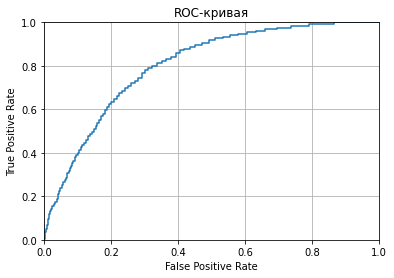

In [162]:
show_metrics(train_target, cv_preds,cv_pred_probas[:, 1])

Подберем гиперпараметры для модели и вновь  оценим ее качество на кросс-валидации.

In [63]:
param_grid = {'estimator__n_estimators': [100, 500, 1000],
              'estimator__max_features': ["sqrt", "log2"],
              'estimator__max_depth': [None, 10, 15, 30],
              'estimator__min_samples_leaf': [1, 2, 5]}

gsv = GridSearchCV(rf_pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)

In [64]:
gsv.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Type',
                                                                          'PaymentMethod',
                                                                          'InternetService'])])),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [None, 10, 15, 30],
                         'estimator__max_features': ['sqrt', 'log2'],
       

In [66]:
gsv.best_params_

{'estimator__max_depth': 10,
 'estimator__max_features': 'sqrt',
 'estimator__min_samples_leaf': 5,
 'estimator__n_estimators': 500}

In [65]:
gsv.best_score_

0.8235034490522132

In [77]:
gsv.cv_results_['std_test_score'][gsv.best_index_]

0.005560984725091982

In [79]:
# Подготовим данные для модели
ord_encoder = OrdinalEncoder()
rf_best = RandomForestClassifier(class_weight='balanced', random_state=0)

ct = ColumnTransformer([("ord_encoder", ord_encoder, cat_columns)], remainder='passthrough')
rf_pipe_best = Pipeline([('preprocess', ct), ('estimator', rf_best)])
rf_pipe_best.set_params(**gsv.best_params_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_encoder',
                                                  OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService'])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='sqrt', min_samples_leaf=5,
                                        n_estimators=500, random_state=0))])

In [80]:
# Оценим качество модели на  5-fold кросс-валидации
cv_preds = cross_val_predict(rf_pipe_best, train_features, train_target, cv=5)
cv_pred_probas = cross_val_predict(rf_pipe_best, train_features, train_target, cv=5, method='predict_proba')

ROC AUC 0.8233452734855091
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      4139
           1       0.53      0.74      0.62      1495

    accuracy                           0.76      5634
   macro avg       0.71      0.75      0.72      5634
weighted avg       0.80      0.76      0.77      5634



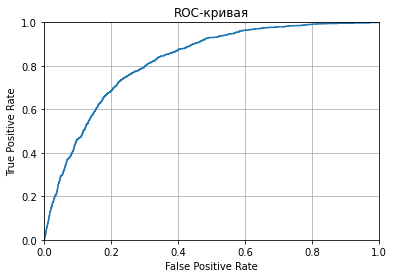

In [81]:
show_metrics(train_target, cv_preds,cv_pred_probas[:, 1])

### 3.2 Градиентный бустинг

In [82]:
cb = CatBoostClassifier(random_state=0)

In [83]:
# Подготовим данные для модели
train_features_cb = train_features.copy()
train_features_cb[cat_columns] = train_features_cb[cat_columns].astype('category')

In [ ]:
# # Оценим качество модели на  5-fold кросс-валидации
cv_preds = cross_val_predict(cb, train_features_cb, train_target, cv=5, fit_params={'cat_features': cat_columns})
cv_pred_probas = cross_val_predict(cb, train_features_cb, train_target, cv=5, method='predict_proba', fit_params={'cat_features': cat_columns})

ROC AUC 0.821866073672328
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4139
           1       0.61      0.49      0.54      1495

    accuracy                           0.78      5634
   macro avg       0.72      0.69      0.70      5634
weighted avg       0.77      0.78      0.77      5634



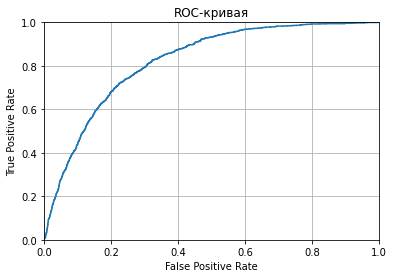

In [65]:
show_metrics(train_target, cv_preds,cv_pred_probas[:, 1])

Подберем гиперпараметры для модели и вновь  оценим ее качество на кросс-валидации.

In [87]:
param_grid = {'learning_rate': [1e-2, 1e-3, 1e-5],
              'depth': [4, 6, 10],
              'iterations': [600, 1000, 2000]}

gsv = GridSearchCV(cb, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)

In [95]:
gsv.fit(train_features_cb, train_target, **{'cat_features': cat_columns})

In [90]:
gsv.best_params_

{'depth': 4, 'iterations': 600, 'learning_rate': 0.01}

In [96]:
gsv.best_score_

0.8284271138760342

In [97]:
gsv.cv_results_['std_test_score'][gsv.best_index_]

0.00812716443953036

In [98]:
cb_best = CatBoostClassifier(random_state=0, verbose=0)
cb_best.set_params(**gsv.best_params_)

In [103]:
# # Оценим качество модели на  5-fold кросс-валидации
cv_preds = cross_val_predict(cb_best, train_features_cb, train_target, cv=5, fit_params={'cat_features': cat_columns})
cv_pred_probas = cross_val_predict(cb_best, train_features_cb, train_target, cv=5, method='predict_proba', fit_params={'cat_features': cat_columns})

ROC AUC 0.8277106340616747
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4139
           1       0.61      0.51      0.56      1495

    accuracy                           0.78      5634
   macro avg       0.72      0.70      0.71      5634
weighted avg       0.77      0.78      0.78      5634



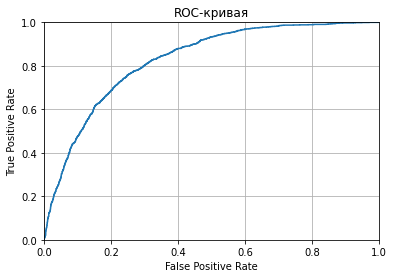

In [104]:
show_metrics(train_target, cv_preds, cv_pred_probas[:, 1])

### 3.3 Нейронные сети

In [117]:
# Конструктор нейронной сети
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=20, num_layers=0, 
                 hidden_dim=64, output_dim=1, p=0.0, div=1):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim

        # if num_layers > 1:
        for i in range(num_layers):
            if num_layers-1 != i:
                self.layers.add_module('layer{}'.format(i), 
                                    torch.nn.Linear(prev_size, hidden_dim))
                self.layers.add_module(f'batchnorm{i}', 
                                        torch.nn.BatchNorm1d(hidden_dim))
                self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
                self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
                prev_size = hidden_dim

            if (div != 1) and (div != 0): 
                hidden_dim = hidden_dim // div

        
        self.layers.add_module('final_linear', 
                               torch.nn.Linear(prev_size, output_dim))  
        self.layers.add_module(f'sigmoid', 
                                torch.nn.Sigmoid())  
        
    def forward(self, input):
        return self.layers(input)

# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == torch.nn.Linear: # Проверка, что слой – полносвязный
        torch.nn.init.xavier_normal_(layer.weight)



# Класс для ранней остановки в ходе обучения модели
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=10, min_delta=0.5):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между f1-метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = None
        self.early_stop = False

    def __call__(self, val_metric):
        if self.best_metric == None:
            self.best_metric = val_metric
        elif val_metric - self.best_metric > self.min_delta:
            self.best_metric = val_metric
            # reset counter if validation loss improves
            self.counter = 0
        elif val_metric - self.best_metric < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

# Класс для создания датасета
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        sample = {"data": data, "labels": label}
        return sample

# Функция для обучения модели
def trainer(model, datasettrain, datasetvalid, loss_function, optimizer, 
            epochs, check_val_metric, patience, min_delta, batch_size=64):

    model.to(device)
    early_stopping = CustomEarlyStopping(patience=patience, min_delta=min_delta)

    val_X = datasetvalid.data
    val_y = datasetvalid.labels
    train_dataloader = DataLoader(datasettrain, batch_size=batch_size, shuffle=True, drop_last=True)
  
  # Обучаем модель заданное количество эпох
    for epoch in notebook.tqdm(range(epochs)):
        for batch in train_dataloader:
            batch_X = batch['data'].to(device)
            batch_y = batch['labels'].to(device)

            optimizer.zero_grad()

            predictions = model.forward(batch_X).flatten()
            train_loss = loss_function(predictions, batch_y)

            train_loss.backward()
            optimizer.step()

        # Проверяем качество на валидационной выборке
        model.eval()
        val_pred = model.forward(val_X.to(device)).flatten()
        auc = roc_auc_score(val_y.cpu().numpy(), val_pred.cpu().detach().numpy())

        early_stopping(auc)
        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            break

        # Выводим метрики на экран каждые "check_val_metric" эпох
        if check_val_metric != 0 and (epoch % check_val_metric == 0 or epoch == epochs - 1):
            print(epoch)
            print('train_loss_BCE=', train_loss.cpu().detach().numpy()) 
            print('test_AUC=', auc)

        torch.cuda.empty_cache()
    return auc, val_pred.cpu().detach().numpy()


# Функция, которая обучает нейронную сеть на всех данных
def train_no_validation(model, datasetfull, loss_function, optimizer, 
                        epochs, batch_size=64):
    model.to(device)
    train_dataloader = DataLoader(datasetfull, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Обучаем модель заданное количество эпох
    for epoch in notebook.tqdm(range(epochs)):
        for batch in train_dataloader:
            batch_X = batch['data'].to(device)
            batch_y = batch['labels'].to(device)

            optimizer.zero_grad()

            predictions = model.forward(batch_X).flatten()
            train_loss = loss_function(predictions, batch_y)

            train_loss.backward()
            optimizer.step()

In [79]:
# Числовые признаки, которые необходимо масштабировать
columns_to_scale = ['MonthlyCharges', 'DaysWithCompany']

In [80]:
ohe = OneHotEncoder(drop='first')
scaler = StandardScaler()
ct = ColumnTransformer([("ohe", ohe, cat_columns), 
                        ("scaler", scaler, columns_to_scale)], remainder='passthrough')

In [86]:
train_X, val_X, train_y, val_y = train_test_split(train_features, train_target, test_size=0.2, stratify=train_target, random_state=0)

for d, n in zip([train_X, train_y, val_X, val_y], ['train_X', 'train_y', 'val_X', 'val_y']):
    print(n+' shape:', d.shape)

train_X shape: (4507, 16)
train_y shape: (4507,)
val_X shape: (1127, 16)
val_y shape: (1127,)


In [88]:
train_X = ct.fit_transform(train_X)
val_X = ct.transform(val_X)

for d, n in zip([train_X, val_X], ['train_X', 'val_X']):
    print(n+' shape:', d.shape)

train_X shape: (4507, 20)
val_X shape: (1127, 20)


In [176]:
dataset_train = CustomDataset(torch.FloatTensor(train_X), torch.FloatTensor(train_y.values))
dataset_valid = CustomDataset(torch.FloatTensor(val_X), torch.FloatTensor(val_y.values))

In [177]:
model = Perceptron(input_dim=20, num_layers=2, hidden_dim=10, output_dim=1, p=0.8, div=2)
model.apply(init_weights)

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=20, out_features=10, bias=True)
    (batchnorm0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.8, inplace=False)
    (final_linear): Linear(in_features=10, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [178]:
auc_nn, val_pred = trainer(model=model,
                 datasettrain=dataset_train,
                 datasetvalid=dataset_valid,
                 loss_function=torch.nn.BCELoss(),
                 optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), 
                 epochs=100,
                 check_val_metric=1,
                 patience=5,
                 min_delta=0.001,
                 batch_size=128)

  0%|          | 0/100 [00:00<?, ?it/s]

0
train_loss_BCE= 1.3286431
test_AUC= 0.466862165349878
1
train_loss_BCE= 0.8082899
test_AUC= 0.5864435396571502
2
train_loss_BCE= 0.6543217
test_AUC= 0.6499119448079751
3
train_loss_BCE= 0.57040954
test_AUC= 0.6769061121613107
4
train_loss_BCE= 0.61218333
test_AUC= 0.6981282212851211
5
train_loss_BCE= 0.51283705
test_AUC= 0.718086051734445
6
train_loss_BCE= 0.5213677
test_AUC= 0.7358344239251611
7
train_loss_BCE= 0.554718
test_AUC= 0.7492487034074935
8
train_loss_BCE= 0.4518935
test_AUC= 0.7621096085179261
9
train_loss_BCE= 0.4474348
test_AUC= 0.7728822322395101
10
train_loss_BCE= 0.45644364
test_AUC= 0.7811343770701048
11
train_loss_BCE= 0.52738845
test_AUC= 0.7882716946989159
12
train_loss_BCE= 0.4795372
test_AUC= 0.7941366551952562
13
train_loss_BCE= 0.42657915
test_AUC= 0.799173573748243
14
train_loss_BCE= 0.45448416
test_AUC= 0.8044366891247798
15
train_loss_BCE= 0.5060726
test_AUC= 0.8078377199360187
16
train_loss_BCE= 0.5500256
test_AUC= 0.8121354595834747
17
train_loss_BCE= 0.

ROC AUC 0.8337534131484982
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       828
         1.0       0.62      0.52      0.56       299

    accuracy                           0.79      1127
   macro avg       0.73      0.70      0.71      1127
weighted avg       0.78      0.79      0.78      1127



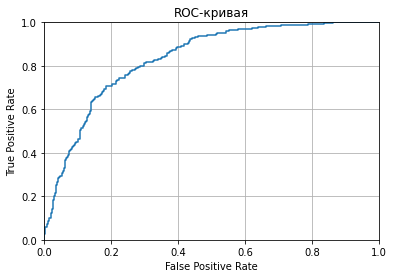

In [199]:
show_metrics(dataset_valid.labels.numpy(), val_pred > 0.5, val_pred)

### 3.4 Резюме

В ходе проверки моделей, были получены следующие результаты:  

|Модель|ROC AUC|Accuracy|F1|
|--|--|--|--|
|Случайный лес|0.82|0.76|0.62|  
|Градиентный бустинг|0.83|0.78|0.56| 
|Нейронная сеть|0.83|0.79|0.56|   

В качестве финальной модели будет взята модель случайного леса, так как ее качество лишь незначительно хуже чем качество нейронной сети, но при этом она интерпретируема и более проста, а также в отличие от градиентного бустинга смогла распознать более 70% объектов положительного класса при пороге классификатора в 0.5.

## 4 Тестирование модели

### 4.1 Оценка качества работы случайного леса на тестовых данных

In [105]:
# Подготовим данные для модели
ord_encoder = OrdinalEncoder()
rf_best = RandomForestClassifier(class_weight='balanced', random_state=0)

ct = ColumnTransformer([("ord_encoder", ord_encoder, cat_columns)], remainder='passthrough')
rf_pipe_best = Pipeline([('preprocess', ct), ('estimator', rf_best)])

best_params = {'estimator__max_depth': 10,
               'estimator__max_features': 'sqrt',
               'estimator__min_samples_leaf': 5,
               'estimator__n_estimators': 500}

rf_pipe_best.set_params(**best_params)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_encoder',
                                                  OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService'])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='sqrt', min_samples_leaf=5,
                                        n_estimators=500, random_state=0))])

In [140]:
rf_pipe_best.fit(train_features, train_target)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_encoder',
                                                  OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService'])])),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='sqrt', min_samples_leaf=5,
                                        n_estimators=500, random_state=0))])

In [141]:
test_preds = rf_pipe_best.predict(test_features)
test_pred_probas = rf_pipe_best.predict_proba(test_features)

ROC AUC 0.8211772456017981
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1035
           1       0.52      0.72      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.75      0.76      1409



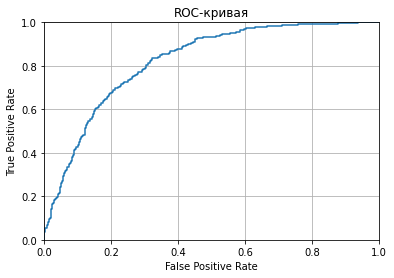

In [143]:
show_metrics(test_target, test_preds, test_pred_probas[:, 1])

Посмотрим на матрицу ошибок.

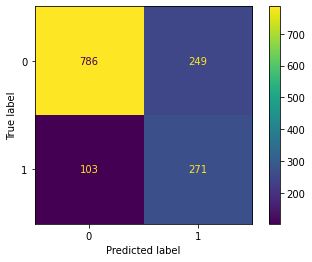

In [144]:
cm = confusion_matrix(test_target, test_preds, labels=cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb.classes_)
disp.plot()
plt.show()

На матрице ошибок видно, что из всех объектов положительного класса наш алгоритм верно определил более чем две трети. При этом, среди всех объектов, которые наш алгоритм отнес к положительному классу, он оказался прав лишь в чуть больше чем 50% случаев.

В нашей выборке 73% объектов обладают классом 0. Это означает, что если мы всегда будем предсказывать негативный класс, то будем правы в 73% случаев. Таким образом Accuracy 75% говорит о том, что нам хоть и ненамного, но удалось улучшить результат случайной модели.  
Однако, что гораздо более важно для нас, показатель ROC AUC равен 82%. Это означает, что 82% пар объектов вида (объект класса 1, объект класса 0), наш алгоритм верно упорядочил, т.е. предсказание классификатора на объекте положительного класса будут выше, нежели на объекте негативного класса. 

### 4.2 Интерпретация модели Случайного леса

In [131]:
feature_names = cat_columns + [el for el in list(test_features.columns) if el not in cat_columns]

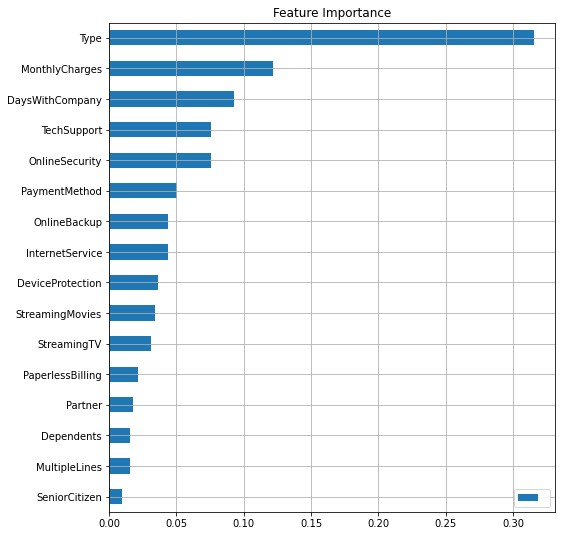

In [132]:
feature_importance_plot(rf_pipe_best['estimator'].feature_importances_, feature_names)

Наибольший вклад в предсказания модели вносят такие признаки как:
- `Type` - тип оплаты
- `MonthlyCharges` - размер ежемесячной оплаты: те клиенты, у которых более высокая оплата, с большей вероятностью уходят в отток.
- `DaysWithCompany` - количество дней, которое клиент провел с компанией

По каждому типу оплаты посмотрим на соотношение ушедших и действующих пользователей:

In [267]:
for type_ in data['Type'].unique():
    print(type_+':', data[data['Type'] == type_]['Churned'].mean())

Two year: 0.02831858407079646
Month-to-month: 0.4270967741935484
One year: 0.11269517990495587


Наибольший процент ушедших клиентов находится среди тех, кто выбрал помесячную оплату.

Посмотрим среднее количество ушедших клиентов в зависмости от количества дней работы с компанией:

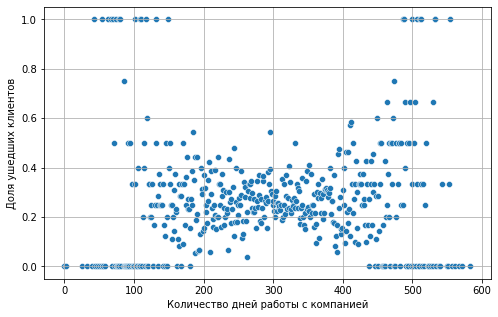

In [310]:
tbl = data.groupby('DaysWithCompany')['Churned'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=tbl['DaysWithCompany'], y=tbl['Churned']);
plt.grid()
plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Количество дней работы с компанией');

В данном случае интерпетировать зависимость достаточно сложно. Скорее всего данный признак следует рассматривать вкупе с другими признаками.

## 5 Вывод

Задача данного проекта состояла в том, чтобы научиться прогнозировать отток клиентов.  
В ходе проекта был проведен исследовательский анализ данных. После проведения исследовательского анализа, был произведен отбор признаков, которые примут участие в дальнейшем обучении моделей. Затем для прогнозирования оттока клиентов была проведена оценка качества работы следующих моделей машинного обучения:  
- Случайный лес
- Градиентный бустинг
- Нейронная сеть

Были получены следующие результаты:  

|Модель|ROC AUC|Accuracy|F1|
|--|--|--|--|
|Случайный лес|0.82|0.76|0.62|  
|Градиентный бустинг|0.83|0.78|0.56| 
|Нейронная сеть|0.83|0.79|0.56|   

В качестве финальной модели было принято решение использовать модель случайного леса,  так как она проще, более интрепретируема, а также не сильно уступает нейронной сети в качестве, и в отличие от модели градиентного бустинга, смогла охватить более 70% объектов положительного класса при пороге классификатора в 0.5.

Затем, работа случайного леса была проверена на тестовом наборе данных. Качество ROC AUC, которое удалось получить на тестовой выборке составило 0.82.  
Затем, предсказания модели были проинтерпретированы. Признаками, которые внесли наибольший вклад в предсказания модели, оказались:  
- `Type` - тип оплаты (наибольший процент ушедших клиентов находится среди тех, кто выбрал помесячную оплату)
- `DaysWithCompany` - количество дней, которое клиент провел с компанией
- `MonthlyCharges` - размер ежемесячной оплаты (те клиенты, у которых более высокая оплата, с большей вероятностью уходят в отток).

Также в качестве рекомендации стоит добавить, что если мобильный оператор решит использовать некий порог для отсечения пользователей которым стоит предлагать промоакции в целях удержания, и при этом постараться максимально охватить пользователей, подверженных риску ухода, порог  стоит выбирать ниже 0.5, возможно, расссмотреть диапазон 0.2-0.4. 


